# Model Structured Neural Network

### Initialisation

### Model Structured Neural Network

In [1]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from nnodely import *
from nnodely.support.earlystopping import select_best_model
from pathlib import Path

# Models folder
path_folder = "trained_models"

# telemetries folder
path_train = "telemetries/training"
path_val   = "telemetries/validation"
path_test  = "telemetries/test"

# Import parameters:
vehicle_data = pd.read_csv("parameters/params.csv")
data_stats   = pd.read_csv("parameters/data_info.csv")
data_stats   = data_stats.iloc[0]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.2 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [2]:
# NNodely instantiation
lateral_model = nnodely(visualizer=MPLNotebookVisualizer(),seed=1,workspace=path_folder,save_history=False)

# ------------------------------------------- #
###  MODEL STRUCTURED NEURAL NETWORK MODEL  ###
# ------------------------------------------- #

# -----------------------------------------
# Inputs
# -----------------------------------------
yaw_rate = Input('yawRate')         # [rad/s] yaw rate
yaw_angle = Input('yawAngle')       # [deg] yaw angle
vx       = Input('vxCG')            # [m/s] longitudinal velocity
steer    = Input('handwheelAngle')  # [rad] steering wheel angle
ax       = Input('axCG')            # [m/s^2] longitudinal acceleration

# -----------------------------------------
# Hyperparameters
# -----------------------------------------
past_window = 10   # past samples 0.5s

# channels definition
n_channels_vx    = 2
n_channels_delta = 5
n_channels_ax    = 2

# -----------------------------------------
# Fuzzy: 
# -----------------------------------------
# channels centers
chan_centers_vx  = list(np.linspace(data_stats['vx_min'], data_stats['vx_max'], n_channels_vx))
chan_centers_ax  = list(np.linspace(-np.fmin(-data_stats['ax_min'],data_stats['ax_max']), np.fmin(-data_stats['ax_min'],data_stats['ax_max']), n_channels_ax))
chan_centers_delta = list(np.linspace(-data_stats['delta_max'], data_stats['delta_max'], n_channels_delta))

# Define the equilibrium points values for linearisation
vx_list, ax_list, delta_list = [],[],[]
for i in range(n_channels_vx):
    vx_list.append(Constant('vx_'+str(i),values=chan_centers_vx[i]))
for i in range(n_channels_ax):
    ax_list.append(Constant('ax_'+str(i),values=chan_centers_ax[i]))
for i in range(n_channels_delta):
    delta_list.append(Constant('delta_'+str(i),values=chan_centers_delta[i]))

# fuzzification
#abs_steer = Relu(steer.last()) + Relu(-steer.last())
fuzz_ss_delta   = Fuzzify(centers=chan_centers_delta,functions='Triangular')(steer.last())
fuzz_ss_ax      = Fuzzify(centers=chan_centers_ax,functions='Triangular')(ax.last())
fuzz_ss_vx      = Fuzzify(centers=chan_centers_vx,functions='Triangular')(vx.last())

# -------------------------------------------
# Parametric Function: understeer correction
# -------------------------------------------
def understeer_corr_local(delta,vx,ax,        # model inputs
                    delta_0,vx_0,ax_0,  # equilibrium points
                    k1,k2,k3,k4         # learnable parameters
                    ):
    return (k1 + k2*(delta-delta_0) + k3*(vx-vx_0) + k4*(ax-ax_0))

understeer_corr = ParamFun(understeer_corr_local)

def Generator_understeer_corr(idx_list):
    def understeer_corr_map(delta,vx,ax):
        idx_delta = idx_list[0]
        idx_speed = idx_list[1]
        idx_ax = idx_list[2]
        k1 = Parameter('k1_' + str(idx_delta) + str(idx_speed) + str(idx_ax),values=[[1e-5]])
        k2 = Parameter('k2_' + str(idx_delta) + str(idx_speed) + str(idx_ax), values=[[1e-5]])
        k3 = Parameter('k3_' + str(idx_delta) + str(idx_speed) + str(idx_ax), values=[[1e-5]])
        k4 = Parameter('k4_' + str(idx_delta) + str(idx_speed) + str(idx_ax), values=[[1e-5]])
        delta_0 = delta_list[idx_delta]
        vx_0    = vx_list[idx_speed]
        ax_0    = ax_list[idx_ax]
        return understeer_corr(delta,vx,ax,delta_0,vx_0,ax_0,k1,k2,k3,k4)
    return understeer_corr_map

# -----------------------------------------
# FIR filter
# -----------------------------------------
steer_dyn = Fir(W='Fir_steer', W_init='init_negexp')(steer.sw(past_window))
vx_dyn    = Fir(W='Fir_vx', W_init='init_negexp')(vx.sw(past_window))
ax_dyn    = Fir(W='Fir_ax', W_init='init_negexp')(ax.sw(past_window))

# -----------------------------------------
# Local Model
# -----------------------------------------
yaw_rate_est = LocalModel(input_function = Generator_understeer_corr,pass_indexes=True)((steer_dyn,vx_dyn,ax_dyn),
                                                                                      (fuzz_ss_delta,fuzz_ss_vx,fuzz_ss_ax))

# -----------------------------------------
# Outputs
# -----------------------------------------
yaw_rate_out = Output('yaw_rate',yaw_rate_est)                                              # yaw rate [deg/s]    
yaw_out      = Output('yaw_angle',Integrate(yaw_rate_est,int_name='yawAngle_int',
                                            der_name='yawRate_int',method='trapezoidal'))       # yaw angle [deg]

# -----------------------------------------
# Minimization and neuralization
# -----------------------------------------
lateral_model.addModel('lateral_model',[yaw_rate_out,yaw_out])

lateral_model.addMinimize('yaw_rate_error',
                    yaw_rate.next(),
                    yaw_rate_out,
                    loss_function='mse')
lateral_model.addMinimize('yaw_angle_error',
                    yaw_angle.next(),
                    yaw_out,
                    loss_function='mse')

lateral_model.neuralizeModel(sample_time=0.05)


[neuralizeModel] Closed loop on yawAngle_int with sample in the future.


[neuralizeModel] Connect on yawRate_int with sample in the future.


================================ nnodely Model =================================
{'Constants': {'Constant109': {'dim': 1, 'values': [0.5]},
               'SampleTime': {'dim': 1, 'values': 0.05},
               'ax_0': {'dim': 1, 'values': [-5.0]},
               'ax_1': {'dim': 1, 'values': [5.0]},
               'delta_0': {'dim': 1, 'values': [-85.0]},
               'delta_1': {'dim': 1, 'values': [-42.5]},
               'delta_2': {'dim': 1, 'values': [0.0]},
               'delta_3': {'dim': 1, 'values': [42.5]},
               'delta_4': {'dim': 1, 'values': [85.0]},
               'vx_0': {'dim': 1, 'values': [12.5]},
               'vx_1': {'dim': 1, 'values': [65.0]}},
 'Functions': {'FFuzzify15': {'centers': [-85.0, -42.5, 0.0, 42.5, 85.0],
                              'dim_out': {'dim': 5},
                              'functions': 'Triangular',
                              'names': 'Triangular'},
               'FFuzzify16': {'centers': [-5.0, 5.0],
                  

# Training

============================ nnodely Model Dataset =============================
Dataset Name:                 training_telem
Number of files:              2
Total number of samples:      10352
Shape of yawAngle_int:        (10352, 1, 1)
Shape of axCG:                (10352, 10, 1)
Shape of vxCG:                (10352, 10, 1)
Shape of handwheelAngle:      (10352, 10, 1)
Shape of yawRate_int:         (10352, 2, 1)
Shape of yawAngle:            (10352, 1, 1)
Shape of yawRate:             (10352, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 valid_telem
Number of files:              1
Total number of samples:      7748
Shape of yawAngle_int:        (7748, 1, 1)
Shape of axCG:                (7748, 10, 1)
Shape of vxCG:                (7748, 10, 1)
Shape of handwheelAngle:      (7748, 10, 1)
Shape of yawRate_int:         (7748, 2, 1)
Shape of yawAngle:            (7748, 1, 1)
Shape of yawRate:             (7748, 1, 1)


======================== nnodely Model Train Parameters ========================
models:                       ['lateral_model']
num of epochs:                50
update per epochs:            18
└>len(train_indexes)//(batch_size+step)
shuffle data:                 True
prediction samples:           500
step:                         250
closed loop:                  {}
connect:                      {}
train dataset:                training_telem
	- batch size:                256
	- num of samples:            10352
	- num of first samples:      9352
validation dataset:           valid_telem
	- batch size:                256
	- num of samples:            7748
	- num of first samples:      7248
minimizers:                   {'yaw_angle_error': {'A': 'SamplePart473',
                                                   'B': 'Add468',
                                                   'gain': 0.1,
                                                   'loss': 'mse'},
                              

|   1/50   |2.065e+01|5.111e+00|1.476e+02|1.118e+01|8.411e+01|8.146e+00|


|   2/50   |3.231e+00|2.782e+00|1.277e+01|5.665e+00|8.001e+00|4.223e+00|


|   3/50   |1.707e+00|2.399e+00|3.020e+00|3.805e+00|2.364e+00|3.102e+00|


|   4/50   |1.493e+00|2.229e+00|1.538e+00|2.711e+00|1.515e+00|2.470e+00|


|   5/50   |1.389e+00|2.149e+00|1.402e+00|2.506e+00|1.395e+00|2.327e+00|


|   6/50   |1.362e+00|2.110e+00|1.298e+00|2.974e+00|1.330e+00|2.542e+00|


|   7/50   |1.309e+00|2.027e+00|1.245e+00|2.590e+00|1.277e+00|2.309e+00|


|   8/50   |1.273e+00|2.013e+00|1.198e+00|3.017e+00|1.236e+00|2.515e+00|


|   9/50   |1.242e+00|1.997e+00|1.232e+00|3.063e+00|1.237e+00|2.530e+00|


|  10/50   |1.209e+00|1.929e+00|1.219e+00|2.820e+00|1.214e+00|2.375e+00|


|  11/50   |1.188e+00|1.907e+00|1.227e+00| 2.8e+00 |1.207e+00|2.353e+00|


|  12/50   |1.166e+00|1.882e+00|1.158e+00|2.848e+00|1.162e+00|2.365e+00|


|  13/50   |1.133e+00|1.868e+00|1.152e+00|2.845e+00|1.142e+00|2.356e+00|


|  14/50   |1.157e+00|1.839e+00|1.293e+00|2.831e+00|1.225e+00|2.335e+00|


|  15/50   |1.114e+00|1.842e+00|1.149e+00|3.145e+00|1.131e+00|2.494e+00|


|  16/50   |1.093e+00|1.791e+00|1.142e+00|2.924e+00|1.118e+00|2.358e+00|


|  17/50   |1.112e+00|1.847e+00|1.250e+00|3.581e+00|1.181e+00|2.714e+00|


|  18/50   |1.073e+00|1.806e+00|1.158e+00|3.792e+00|1.116e+00|2.799e+00|


|  19/50   |1.074e+00|1.754e+00|1.138e+00|3.238e+00|1.106e+00|2.496e+00|


|  20/50   |1.042e+00|1.732e+00|1.183e+00|2.884e+00|1.113e+00|2.308e+00|


|  21/50   |1.032e+00|1.728e+00|1.176e+00|3.172e+00|1.104e+00| 2.45e+00|


|  22/50   | 1.03e+00|1.851e+00|1.304e+00|4.485e+00|1.167e+00|3.168e+00|


|  23/50   |1.074e+00|1.758e+00|1.566e+00|3.449e+00|1.320e+00|2.604e+00|


|  24/50   |1.050e+00|1.682e+00|1.389e+00|3.075e+00| 1.22e+00|2.378e+00|


|  25/50   |1.038e+00|1.679e+00|1.486e+00|3.088e+00|1.262e+00|2.383e+00|


|  26/50   |9.952e-01|1.629e+00|1.218e+00|2.855e+00|1.107e+00|2.242e+00|


|  27/50   |1.019e+00|1.668e+00|1.409e+00|3.095e+00|1.214e+00|2.382e+00|


|  28/50   |9.718e-01|1.605e+00|1.107e+00|2.917e+00| 1.04e+00|2.261e+00|


|  29/50   |9.476e-01|1.648e+00| 1.05e+00|3.435e+00|9.987e-01|2.541e+00|


|  30/50   |9.511e-01|1.703e+00|1.076e+00|3.688e+00|1.013e+00|2.695e+00|


|  31/50   |1.020e+00|1.601e+00|1.533e+00|2.467e+00|1.276e+00|2.034e+00|


|  32/50   |1.032e+00|1.612e+00|1.540e+00|2.930e+00|1.286e+00|2.271e+00|


|  33/50   |9.653e-01|1.595e+00|1.185e+00|2.710e+00|1.075e+00|2.153e+00|


|  34/50   |9.765e-01|1.567e+00|1.219e+00| 2.83e+00|1.098e+00|2.198e+00|


|  35/50   |9.498e-01|1.585e+00|1.128e+00|2.974e+00|1.039e+00|2.279e+00|


|  36/50   |9.476e-01|1.695e+00|1.143e+00|3.951e+00|1.045e+00|2.823e+00|


|  37/50   |9.531e-01|1.524e+00|1.114e+00|2.538e+00|1.034e+00|2.031e+00|


|  38/50   |9.523e-01|1.533e+00|1.043e+00|2.718e+00|9.977e-01|2.126e+00|


|  39/50   |9.457e-01|1.597e+00|1.151e+00|3.327e+00|1.048e+00|2.462e+00|


|  40/50   |9.287e-01|1.578e+00|9.886e-01|3.371e+00|9.587e-01|2.475e+00|


|  41/50   | 9.53e-01|1.501e+00|1.160e+00|2.228e+00|1.057e+00|1.865e+00|


|  42/50   |9.408e-01|1.576e+00|1.199e+00|3.421e+00|1.070e+00|2.499e+00|


|  43/50   |1.012e+00|1.557e+00|1.587e+00|3.173e+00|1.299e+00|2.365e+00|


|  44/50   | 9.25e-01|1.552e+00|9.699e-01|2.938e+00|9.474e-01|2.245e+00|


|  45/50   |8.979e-01|1.558e+00|9.011e-01|3.260e+00|8.995e-01|2.409e+00|


|  46/50   |9.037e-01|1.554e+00|9.288e-01|3.322e+00|9.163e-01|2.438e+00|


|  47/50   |9.121e-01|1.577e+00|8.902e-01|3.381e+00|9.011e-01|2.479e+00|


|  48/50   |9.104e-01|1.513e+00|9.205e-01|2.839e+00|9.155e-01|2.176e+00|


|  49/50   |9.216e-01|1.465e+00|1.038e+00|2.635e+00|9.799e-01|2.050e+00|


|  50/50   |9.266e-01|1.471e+00|1.063e+00|2.783e+00|9.946e-01|2.127e+00|
|----------------------------------------------------------------------|
============================ nnodely Training Time =============================
Total time of Training:       3804.372707128525


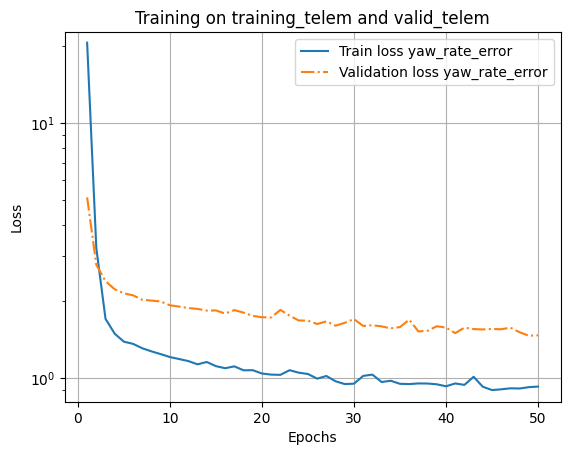

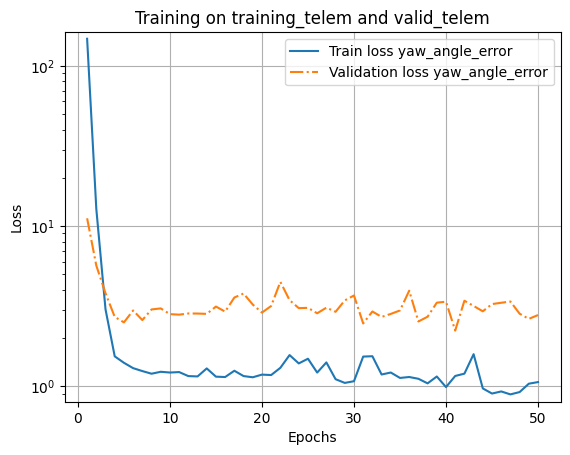

Selected the model at the epoch 41.


======================== nnodely Model Train Parameters ========================
models:                       ['lateral_model']
num of epochs:                10
update per epochs:            18
└>len(train_indexes)//(batch_size+step)
shuffle data:                 True
prediction samples:           500
step:                         250
closed loop:                  {}
connect:                      {}
train dataset:                training_telem
	- batch size:                256
	- num of samples:            10352
	- num of first samples:      9352
validation dataset:           valid_telem
	- batch size:                256
	- num of samples:            7748
	- num of first samples:      7248
minimizers:                   {'yaw_angle_error': {'A': 'SamplePart473',
                                                   'B': 'Add468',
                                                   'gain': 0.1,
                                                   'loss': 'mse'},
                              

|   1/10   |9.230e-01|1.576e+00| 1.01e+00|2.927e+00|9.664e-01|2.252e+00|


|   2/10   |9.147e-01|1.540e+00|8.948e-01| 2.74e+00|9.047e-01|2.140e+00|


|   3/10   |9.029e-01|1.528e+00|8.923e-01|2.795e+00|8.976e-01|2.162e+00|


|   4/10   |9.119e-01|1.563e+00|8.854e-01|3.037e+00|8.987e-01|2.300e+00|


|   5/10   |9.120e-01|1.538e+00|8.883e-01|2.908e+00|9.002e-01|2.223e+00|


|   6/10   |9.155e-01|1.543e+00| 8.85e-01|2.846e+00|9.003e-01|2.195e+00|


|   7/10   |9.071e-01|1.537e+00|8.853e-01|2.756e+00|8.962e-01|2.147e+00|


|   8/10   |9.102e-01|1.534e+00|8.911e-01|2.803e+00|9.007e-01|2.169e+00|


|   9/10   |9.166e-01|1.530e+00|9.027e-01|2.908e+00|9.097e-01|2.219e+00|


|  10/10   |9.048e-01|1.546e+00|8.685e-01|3.019e+00|8.867e-01|2.282e+00|
|----------------------------------------------------------------------|
============================ nnodely Training Time =============================
Total time of Training:       768.1353743076324


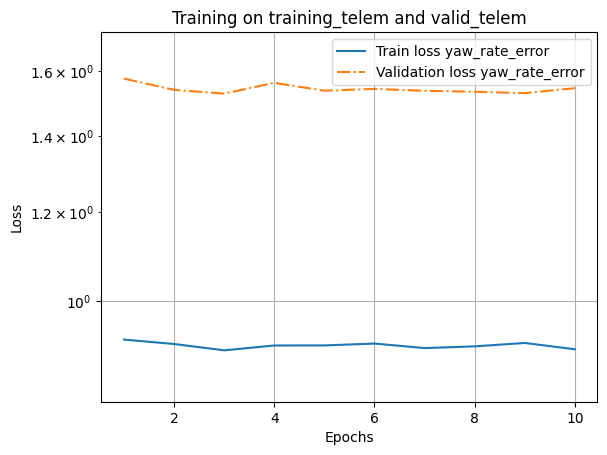

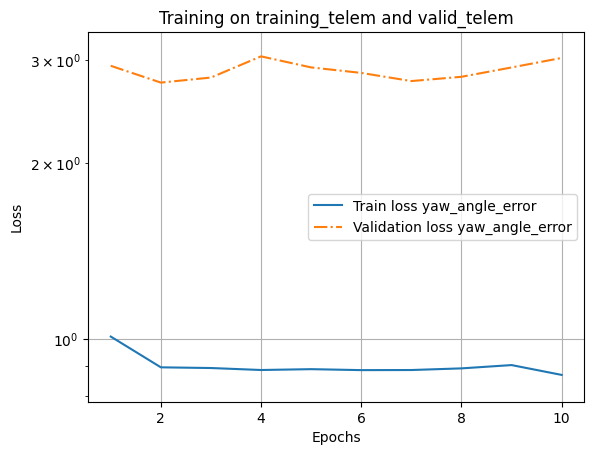

Selected the model at the epoch 2.


=============================== Save JSON Model ================================
Model saved in:               trained_models/MS_NN.json


In [3]:
# -----------------------------------------
# Load Datasets
# -----------------------------------------
lateral_model.loadData(name='training_telem',source=path_train,format=['','handwheelAngle','vxCG','axCG','ayCG',('yawAngle','yawAngle_int'),('yawRate','yawRate_int')],skiplines=1)
lateral_model.loadData(name='valid_telem',   source=path_val,  format=['','handwheelAngle','vxCG','axCG','ayCG',('yawAngle','yawAngle_int'),('yawRate','yawRate_int')],skiplines=1)

# -----------------------------------------
# Training
# -----------------------------------------
num_epochs = 10
batch_size = 256
learn_rate = 1e-3
early_stop_patience = 5 
n_prediction = 500   # 25s of prediction
training_pars = {'train_dataset':'training_telem',
                 'validation_dataset':'valid_telem',
                 'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate,
                 'shuffle_data':True,
                 'optimizer':'Adam',
                 'select_model':select_best_model,
                 'prediction_samples':n_prediction, 
                 'step':int(0.5*n_prediction),
                 'minimize_gain':{'yaw_rate_error':1.0, 'yaw_angle_error':0.1},
                 'early_stopping_params':{'patience':early_stop_patience,'error':'yaw_rate_error', 'threshold':0.05}}

# High-learning rate pre-training
lateral_model.trainModel(training_params=training_pars,num_of_epochs=50,lr=1e-1)
# Fine-tuning train
lateral_model.trainModel(training_params=training_pars)

# -----------------------------------------
# Save json model
# -----------------------------------------
lateral_model.saveModel('MS_NN')

# Analyse results

=============================== Load JSON Model ================================
Model loaded from:            trained_models/MS_NN.json
[neuralizeModel] Closed loop on yawAngle_int with sample in the future.


[neuralizeModel] Connect on yawRate_int with sample in the future.


================================ nnodely Model =================================
{'Constants': {'Constant109': {'dim': 1, 'values': [0.5]},
               'SampleTime': {'dim': 1, 'values': 0.05},
               'ax_0': {'dim': 1, 'values': [-5.0]},
               'ax_1': {'dim': 1, 'values': [5.0]},
               'delta_0': {'dim': 1, 'values': [-85.0]},
               'delta_1': {'dim': 1, 'values': [-42.5]},
               'delta_2': {'dim': 1, 'values': [0.0]},
               'delta_3': {'dim': 1, 'values': [42.5]},
               'delta_4': {'dim': 1, 'values': [85.0]},
               'vx_0': {'dim': 1, 'values': [12.5]},
               'vx_1': {'dim': 1, 'values': [65.0]}},
 'Functions': {'FFuzzify15': {'centers': [-85.0, -42.5, 0.0, 42.5, 85.0],
                              'dim_out': {'dim': 5},
                              'functions': 'Triangular',
                              'names': 'Triangular'},
               'FFuzzify16': {'centers': [-5.0, 5.0],
                  

==================== nnodely Model Results for test_telem ===================
|      Loss     |        mse        |        FVU        |        AIC        |
|               |    small better   |    small better   |    lower better   |
|---------------------------------------------------------------------------|
|yaw_angle_error|     4.664e+01     |     2.311e-04     |     4.762e+06     |
| yaw_rate_error|     1.503e+00     |     7.499e-03     |     3.975e+06     |
|---------------------------------------------------------------------------|
|     Total     |     2.407e+01     |     3.865e-03     |     4.369e+06     |
|---------------------------------------------------------------------------|


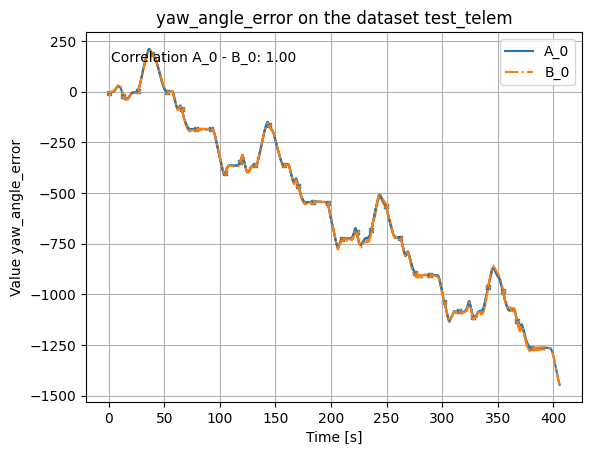

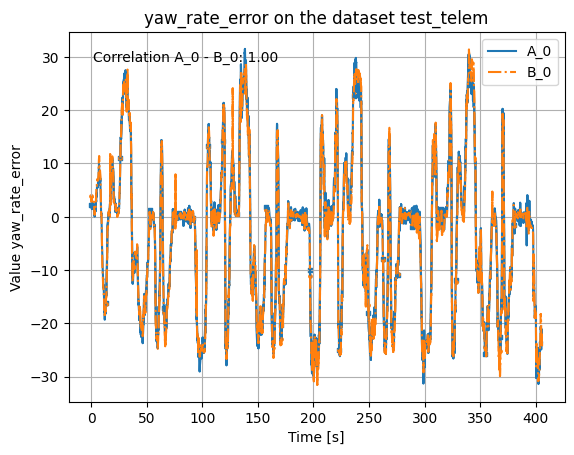

In [4]:

# -----------------------------------------
# Load model and data
# -----------------------------------------    
lateral_model.loadModel('MS_NN')
lateral_model.neuralizeModel()
lateral_model.loadData(name='test_telem', source=path_test, format=['','handwheelAngle','vxCG','axCG','ayCG',('yawAngle','yawAngle_int'),('yawRate','yawRate_int')],skiplines=1)

n_prediction = 500   # 25s of prediction

# -----------------------------------------
# Analyse model
# ----------------------------------------- 
lateral_model.analyzeModel('test_telem' ,prediction_samples=n_prediction )


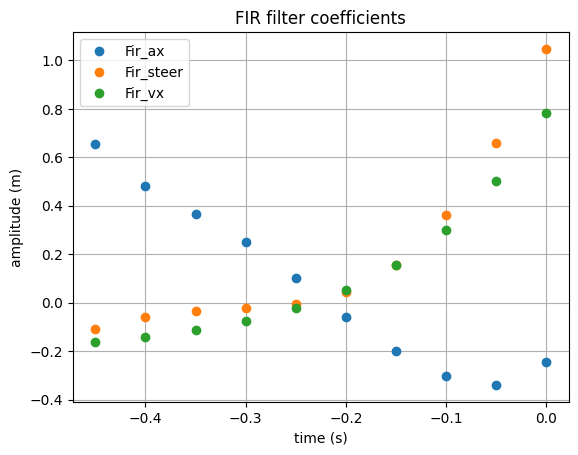

In [5]:
# -----------------------------------------
# Fir filter plot
# ----------------------------------------- 
params_fir = {}
sampling_time = 0.05
idx = 0

# Extract the weights
plt.figure()
for key, value in lateral_model.parameters.items():
    if key.startswith('Fir_'):
        params_fir[key] = lateral_model.parameters[key]
for key, value in params_fir.items():
    vals = np.array(value).flatten()
    t = np.linspace(-sampling_time * (len(vals)-1), 0, len(vals))
    plt.plot(t,vals, 'o', label=key)
    idx += 1
plt.title('FIR filter coefficients')
plt.xlabel('time (s)')
plt.ylabel('amplitude (m)')
plt.legend()
plt.grid(True)

In [6]:
# -----------------------------------------
# NN inference
# ----------------------------------------- 
prediction = 500   # intergal over 25s
window     = 2000
data_sampled = lateral_model.getSamples('test_telem', window=window)

NN_out = lateral_model(inputs=data_sampled,sampled=True,prediction_samples=prediction)
time = 0.05 * np.arange(window)

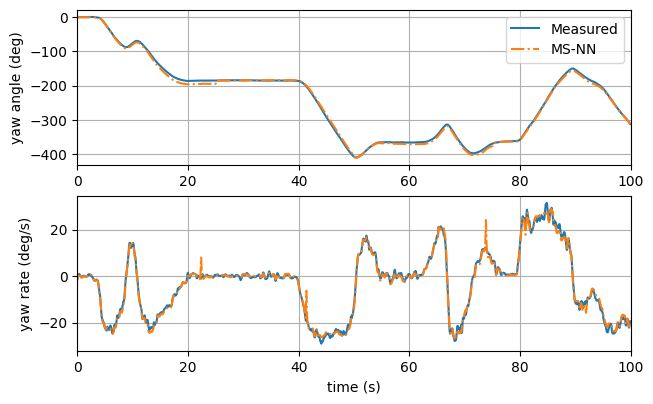

In [7]:
# Yaw prediction plot
width = 7.14         # inches for IEEE column
aspect_ratio = 0.62  # height/width ratio

fig, ax = plt.subplots(2,1,figsize=(width, width * aspect_ratio))

ax[0].plot(time,np.array(data_sampled['yawAngle']).squeeze(), label='Measured')
ax[0].plot(time,NN_out['yaw_angle'], '-.', label='MS-NN')  
ax[0].set_xlim(0,100)
ax[0].set_ylabel('yaw angle (deg)')
ax[0].legend()
ax[0].grid()

# Yaw rate prediction plot
ax[1].plot(time,np.array(data_sampled['yawRate']).squeeze(), label='measured')
ax[1].plot(time,NN_out['yaw_rate'], '-.', label='NN output')  
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('yaw rate (deg/s)')
ax[1].grid()
ax[1].sharex(ax[0])